In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import pearsonr
import itertools
import scipy.stats as ss
from scipy.stats import pointbiserialr
from scipy import stats
from scipy.stats import spearmanr
from dython.nominal import associations
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import kstest
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc,classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn import tree
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef

In [2]:
# Data Insertion
df = pd.read_csv(r'../telco_customers.csv')

In [3]:
# Capitalize all columns for consistency
df.rename(columns = lambda x: "".join([w[0].upper() + w[1:] for w in x.split()]), inplace = True)

# Drop CustomerID, as it holds no bearing on the future predictions
df = df.drop("CustomerID", axis=1)

df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

numerical_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = df.columns.difference(numerical_features)

# Set column data type
df[numerical_features] = df[numerical_features].apply(pd.to_numeric, errors='coerce')

df.dtypes

Gender               object
SeniorCitizen        object
Partner              object
Dependents           object
Tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [4]:
# Get all columns that hold null values
df.columns[df.isnull().sum() != 0].tolist()

['TotalCharges']

In [5]:
# Replace the null values with 0 (it is a result of customers with 1 month tenure)
df["TotalCharges"] = df["TotalCharges"].fillna(0)
df["TotalCharges"].isnull().sum()

0

In [6]:
# Encoding
features_to_one_hot_encode = [feature for feature in categorical_features if df[feature].nunique() > 2]
features_to_label_encode = [feature for feature in categorical_features if df[feature].nunique() == 2]

one_hot_df = pd.get_dummies(df[features_to_one_hot_encode])
one_hot_df.columns = one_hot_df.columns.str.replace(' ', '_')

# Label encode the specified columns
label_encode_df = df[features_to_label_encode].apply(LabelEncoder().fit_transform)

# Combine the encoded dataframes
df_enc = pd.concat([df.drop(columns=features_to_one_hot_encode+features_to_label_encode), one_hot_df, label_encode_df], axis=1)

df_enc.columns

Index(['Tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_Month-to-month',
       'Contract_One_year', 'Contract_Two_year', 'DeviceProtection_No',
       'DeviceProtection_No_internet_service', 'DeviceProtection_Yes',
       'InternetService_DSL', 'InternetService_Fiber_optic',
       'InternetService_No', 'MultipleLines_No',
       'MultipleLines_No_phone_service', 'MultipleLines_Yes',
       'OnlineBackup_No', 'OnlineBackup_No_internet_service',
       'OnlineBackup_Yes', 'OnlineSecurity_No',
       'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes',
       'PaymentMethod_Bank_transfer_(automatic)',
       'PaymentMethod_Credit_card_(automatic)',
       'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check',
       'StreamingMovies_No', 'StreamingMovies_No_internet_service',
       'StreamingMovies_Yes', 'StreamingTV_No',
       'StreamingTV_No_internet_service', 'StreamingTV_Yes', 'TechSupport_No',
       'TechSupport_No_internet_service', 'TechSupport_Yes', 'Chur

In [7]:
del df_enc["TotalCharges"]
del df_enc["MultipleLines_No_phone_service"]
del df_enc["OnlineSecurity_No_internet_service"]
del df_enc["StreamingTV_No_internet_service"]
del df_enc["OnlineBackup_No_internet_service"]
del df_enc["DeviceProtection_No_internet_service"]
del df_enc["InternetService_No"]
del df_enc["MultipleLines_Yes"]
del df_enc["TechSupport_No_internet_service"]
del df_enc["PhoneService"]
del df_enc["MultipleLines_No"]
del df_enc["StreamingMovies_No_internet_service"]

In [8]:
# FIRST APPROACH 

In [9]:
X = df_enc.drop(columns=['Churn'])
y = df_enc['Churn']

# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

print(f"Training features shape: {X_train.shape}")
print(f"Training features shape: {X_test.shape}")
print(f"Training features shape: {X_val.shape}")

Training features shape: (4225, 28)
Training features shape: (1409, 28)
Training features shape: (1409, 28)


In [10]:
def evaluation(y_true, y_pred):

   cm = confusion_matrix(y_true, y_pred)
   tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
   cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

   fig = px.imshow(cm_df.iloc[[1,0],[1,0]],
                labels=dict(x="Predicted", y="Actual", color="Count"),
                x=['Predicted Positive', 'Predicted Negative'],
                y=['Actual Positive', 'Actual Negative'],
                color_continuous_scale=px.colors.sequential.Blues, text_auto=True)

   fig.update_traces(showscale=True) 
   fig.update_layout(title='Confusion Matrix')
   fig.show()

   sensitivity = tp / (tp + fn)
   specificity = tn / (tn + fp)
   precision = tp / (tp + fp)
   mcc = matthews_corrcoef(y_true, y_pred)

   print('Sensitivity (Recall): ' + str(round(sensitivity,2)) + "\n"+'Specificity: '+ str(round(specificity,2))+ "\n"+'Precision: '+ str(round(precision,2)) + "\n"+'MCC: ' + str(round(mcc,2)))

In [275]:
mms = MinMaxScaler() # Normalization
numerical_features = ['Tenure', 'MonthlyCharges']
# fit the scaler on the training data and transform it
X_train[numerical_features] = mms.fit_transform(X_train[numerical_features])

# transform the validation and test data using the same scaler
X_val[numerical_features] = mms.transform(X_val[numerical_features])
X_test[numerical_features] = mms.transform(X_test[numerical_features])

In [270]:
majority_class = y_train.value_counts().idxmax()
X_val['target'] = majority_class

y_true = y_val
y_pred = X_val['target']

In [271]:
evaluation(y_val, y_pred)

Sensitivity (Recall): 0.0
Specificity: 1.0
Precision: nan
MCC: 0.0


In [276]:
dt1 = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_pred_class = dt1.predict(X_val)
y_pred_prob = dt1.predict_proba(X_val)[:,1]

evaluation(y_val, y_pred_class)

Sensitivity (Recall): 0.52
Specificity: 0.82
Precision: 0.5
MCC: 0.33


In [277]:
lr1 = LogisticRegression().fit(X_train, y_train)
y_pred_class = lr1.predict(X_val)
y_pred_prob = lr1.predict_proba(X_val)[:,1]

evaluation(y_val,y_pred_class)

Sensitivity (Recall): 0.6
Specificity: 0.9
Precision: 0.68
MCC: 0.52


In [278]:
svc1 = svm.SVC(probability=True).fit(X_train, y_train)
y_pred_class = svc1.predict(X_val)
y_pred_prob = svc1.predict_proba(X_val)[:,1]

evaluation(y_val,y_pred_class)

Sensitivity (Recall): 0.53
Specificity: 0.9
Precision: 0.64
MCC: 0.46


In [279]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = 1)
# Apply RandomUnderSampler to balance the classes
ros = RandomOverSampler(sampling_strategy = 1)
X_res_over, y_res_over = ros.fit_resample(X_train, y_train)
X_res_smote, y_res_smote = sm.fit_resample(X_train, y_train)

In [280]:
dt2= tree.DecisionTreeClassifier().fit(X_res_over, y_res_over)
y_pred_class = dt2.predict(X_val)
y_pred_prob = dt2.predict_proba(X_val)[:,1]

evaluation(y_val, y_pred_class)

Sensitivity (Recall): 0.5
Specificity: 0.81
Precision: 0.48
MCC: 0.31


In [281]:
dt3= tree.DecisionTreeClassifier().fit(X_res_smote, y_res_smote)
y_pred_class = dt3.predict(X_val)
y_pred_prob = dt3.predict_proba(X_val)[:,1]

evaluation(y_val, y_pred_class)

Sensitivity (Recall): 0.56
Specificity: 0.78
Precision: 0.47
MCC: 0.32


In [282]:
lr2 = LogisticRegression().fit(X_res_over, y_res_over)
y_pred_class = lr2.predict(X_val)
y_pred_prob = lr2.predict_proba(X_val)[:,1]

evaluation(y_val,y_pred_class)

Sensitivity (Recall): 0.8
Specificity: 0.73
Precision: 0.51
MCC: 0.47


In [283]:
lr2 = LogisticRegression().fit(X_res_smote, y_res_smote)
y_pred_class = lr2.predict(X_val)
y_pred_prob = lr2.predict_proba(X_val)[:,1]

evaluation(y_val,y_pred_class)

Sensitivity (Recall): 0.74
Specificity: 0.77
Precision: 0.53
MCC: 0.46


In [284]:
svc2 = svm.SVC().fit(X_res_over, y_res_over)
y_pred_class = svc2.predict(X_val)
evaluation(y_val,y_pred_class)

Sensitivity (Recall): 0.83
Specificity: 0.72
Precision: 0.51
MCC: 0.49


In [285]:
svc3 = svm.SVC().fit(X_res_smote, y_res_smote)
y_pred_class = svc3.predict(X_val)

evaluation(y_val,y_pred_class)

Sensitivity (Recall): 0.72
Specificity: 0.79
Precision: 0.55
MCC: 0.48


In [310]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline

# Set random seed for reproducibility
np.random.seed(42)

parameters = {'logisticregression__penalty': ['l1','l2'],
              'logisticregression__C': [0.1, 0.4, 0.8, 1, 2, 5]
              }

k = 10
cv = StratifiedKFold(n_splits=k,shuffle=False)

mms = MinMaxScaler()
sm = SMOTE(sampling_strategy=1)
lr = LogisticRegression(random_state=42)

pipeline = make_pipeline(mms, sm, lr)
grid_search = GridSearchCV(pipeline, parameters, cv=cv, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)


Best hyperparameters:  {'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}
Best recall score:  0.7873656763590391


In [324]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

parameters = {'logisticregression__penalty': ['l1','l2'],
              'logisticregression__C': [0.1, 0.4, 0.8, 1, 2, 5]
              }

k = 10
cv = StratifiedKFold(n_splits=k)

mms = MinMaxScaler()
sm = SMOTE(sampling_strategy=1, random_state=42)
lr = LogisticRegression(random_state=42)

pipeline = make_pipeline(mms, sm, lr)
grid_search = GridSearchCV(pipeline, parameters, cv=cv, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)


Best hyperparameters:  {'logisticregression__C': 5, 'logisticregression__penalty': 'l2'}
Best recall score:  0.7873577749683945


In [ ]:
######################## SECOND APPROACH

In [8]:
X = df_enc.drop(columns=['Churn'])
y = df_enc['Churn']

# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, random_state = 8)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

Training features shape: (5634, 28)
Testing features shape: (1409, 28)


In [ ]:
my_svm = svm.LinearSVC(C = 0.1)

In [66]:
def calcualte_specificity(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

In [83]:
def run_cv(model, balancing_algorithm = None):
    cv = StratifiedKFold(n_splits=10)
    precision_scores = []
    recall_scores = []
    specificity_scores = []
    mcc_scores = []
    for train, val in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train], X_train.iloc[val]
        y_train_fold, y_val_fold = y_train.iloc[train], y_train.iloc[val]

        if balancing_algorithm != None:
            X_train_fold_balanced, y_train_fold = balancing_algorithm.fit_resample(X_train_fold, y_train_fold)
        else:
            X_train_fold_balanced = X_train_fold

        mms = MinMaxScaler()
        mms.fit(X_train_fold)
        X_train_fold_scaled = mms.transform(X_train_fold_balanced)
        X_val_fold_scaled = mms.transform(X_val_fold)

        model.fit(X_train_fold_scaled, y_train_fold)
        y_pred_val_fold = model.predict(X_val_fold_scaled)
        precision_scores.append(precision_score(y_val_fold, y_pred_val_fold))
        recall_scores.append(recall_score(y_val_fold, y_pred_val_fold))
        specificity_scores.append(calcualte_specificity(y_val_fold, y_pred_val_fold))
        mcc_scores.append(matthews_corrcoef(y_val_fold, y_pred_val_fold))

    average_precision_score = np.mean(precision_scores)
    average_recall_score = np.mean(recall_scores)
    average_specificity_score = np.mean(specificity_scores)
    average_mcc_score = np.mean(mcc_scores)

    # print(f"Average precision: {average_precision_score:.2f} \nAverage recall: {average_recall_score:.2f} \nAverage specificity: {average_specificity_score:.2f} \nAverage mcc: {average_mcc_score:.2f}")
    return average_precision_score, average_recall_score, average_specificity_score, average_mcc_score



In [70]:
alg = dict()

my_lr = LogisticRegression()
my_dt = tree.DecisionTreeClassifier()
my_svm = svm.LinearSVC()

my_smote = SMOTE(sampling_strategy = 1)
my_ros = RandomOverSampler(sampling_strategy = 1)

alg["LR_unbalanced"] = run_cv(my_lr)
alg["LR_SMOTE"] = run_cv(my_lr, my_smote)
alg["LR_ROS"] = run_cv(my_lr, my_ros)

alg["DT_unbalanced"] = run_cv(my_dt)
alg["DT_SMOTE"] = run_cv(my_dt, my_smote)
alg["DT_ROS"] = run_cv(my_dt, my_ros)

alg["SVM_unbalanced"] = run_cv(my_svm)
alg["SVM_SMOTE"] = run_cv(my_svm, my_smote)
alg["SVM_ROS"] = run_cv(my_svm, my_ros)

In [72]:
alg

{'LR_unbalanced': (0.6638894341596502,
  0.5400643932523128,
  0.9011268261451605,
  0.473762153366952),
 'LR_SMOTE': (0.5970808069595922,
  0.6463132595682932,
  0.8430161224608579,
  0.4776779305804224),
 'LR_ROS': (0.516439578150061,
  0.7949165608561582,
  0.7320988301030208,
  0.4734912605777103),
 'DT_unbalanced': (0.4877408697604489,
  0.5043397424269908,
  0.80949537279553,
  0.31073639469347525),
 'DT_SMOTE': (0.48725579382784334,
  0.526559949210956,
  0.8008259123450323,
  0.319777076320903),
 'DT_ROS': (0.4908942053300237,
  0.514538363867223,
  0.8080478435481055,
  0.3180504432807135),
 'SVM_unbalanced': (0.6667624262525772,
  0.5373707600217668,
  0.9030586112566208,
  0.4744436199897013),
 'SVM_SMOTE': (0.5971821863727678,
  0.6469571920914203,
  0.8427757406437344,
  0.4780151971051853),
 'SVM_ROS': (0.5123344966104497,
  0.7976101940867041,
  0.7267883126709738,
  0.4703469693118132)}

In [107]:
def find_best_combination(metric_dict, target):
    best_score = 0
    best_key = None
    for key, value in metric_dict.items():
        score = value[target]
        if score > best_score:
            best_score = score
            best_key = key
    return best_key

print(find_best_combination(alg, 1))

SVM_ROS


In [97]:
hp_algs = dict()

my_dt = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, min_samples_leaf = 5)

my_smote = SMOTE(sampling_strategy = 1)
my_ros = RandomOverSampler(sampling_strategy = 1)

hp_algs["LR_unbalanced"] = run_cv(my_lr)
hp_algs["LR_SMOTE"] = run_cv(LogisticRegression(C = 0.1, penalty = 'l2'), my_smote)
hp_algs["LR_ROS"] = run_cv(LogisticRegression(C = 0.8, penalty = 'l2'), my_ros)

hp_algs["DT_unbalanced"] = run_cv(my_dt)
hp_algs["DT_SMOTE"] = run_cv(my_dt, my_smote)
hp_algs["DT_ROS"] = run_cv(my_dt, my_ros)

hp_algs["SVM_unbalanced"] = run_cv(my_svm)
hp_algs["SVM_SMOTE"] = run_cv(svm.LinearSVC(C = 10), my_smote)
hp_algs["SVM_ROS"] = run_cv(svm.LinearSVC(C = 0.1), my_ros)

In [108]:
print(find_best_combination(hp_algs, 1))

DT_SMOTE


In [110]:
hp_algs

{'LR_unbalanced': (0.6638894341596502,
  0.5400643932523128,
  0.9011268261451605,
  0.473762153366952),
 'LR_SMOTE': (0.5785416335012612,
  0.6718710321059315,
  0.8239648448867936,
  0.4743153179575101),
 'LR_ROS': (0.5145154196486568,
  0.7922274623616905,
  0.7311309004132471,
  0.4701455343813036),
 'DT_unbalanced': (0.5473467959205636,
  0.6254670778160711,
  0.8138373784995052,
  0.4221824380966105),
 'DT_SMOTE': (0.4245412257162835,
  0.8884001451115544,
  0.5673953786159129,
  0.4045862349430453),
 'DT_ROS': (0.4401954871044159,
  0.8520179575548703,
  0.603584191839823,
  0.40670898240519343),
 'SVM_unbalanced': (0.6667624262525772,
  0.5373707600217668,
  0.9030586112566208,
  0.4744436199897013),
 'SVM_SMOTE': (0.601919016791429,
  0.6456375838926174,
  0.8461538909260229,
  0.481457185771493),
 'SVM_ROS': (0.5112337440801368,
  0.8003038273172501,
  0.7246190559338805,
  0.4704590306781472)}

In [109]:
alg

{'LR_unbalanced': (0.6638894341596502,
  0.5400643932523128,
  0.9011268261451605,
  0.473762153366952),
 'LR_SMOTE': (0.5970808069595922,
  0.6463132595682932,
  0.8430161224608579,
  0.4776779305804224),
 'LR_ROS': (0.516439578150061,
  0.7949165608561582,
  0.7320988301030208,
  0.4734912605777103),
 'DT_unbalanced': (0.4877408697604489,
  0.5043397424269908,
  0.80949537279553,
  0.31073639469347525),
 'DT_SMOTE': (0.48725579382784334,
  0.526559949210956,
  0.8008259123450323,
  0.319777076320903),
 'DT_ROS': (0.4908942053300237,
  0.514538363867223,
  0.8080478435481055,
  0.3180504432807135),
 'SVM_unbalanced': (0.6667624262525772,
  0.5373707600217668,
  0.9030586112566208,
  0.4744436199897013),
 'SVM_SMOTE': (0.5971821863727678,
  0.6469571920914203,
  0.8427757406437344,
  0.4780151971051853),
 'SVM_ROS': (0.5123344966104497,
  0.7976101940867041,
  0.7267883126709738,
  0.4703469693118132)}

In [173]:
#print('Best Penalty:', searchv_v .best_estimator_.get_params()['lr__penalty'])
#print('Best C:', searchv_v.best_estimator_.get_params()['lr__C'])

Best Penalty: l2
Best C: 2


In [8]:
X = df_enc.drop(columns=['Churn'])
y = df_enc['Churn']

# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

print(f"Training features shape: {X_train.shape}")
print(f"Training features shape: {X_test.shape}")
print(f"Training features shape: {X_val.shape}")

Training features shape: (4225, 28)
Training features shape: (1409, 28)
Training features shape: (1409, 28)


In [246]:
mms = MinMaxScaler() # Normalization
numerical_features = ['Tenure', 'MonthlyCharges']
# fit the scaler on the training data and transform it
X_train[numerical_features] = mms.fit_transform(X_train[numerical_features])

# transform the validation and test data using the same scaler
X_val[numerical_features] = mms.transform(X_val[numerical_features])
X_test[numerical_features] = mms.transform(X_test[numerical_features])

In [238]:
def evaluation_without_probabilities(y_true, y_pred):

   fpr, tpr, thresholds = roc_curve(y_true, y_pred)  
   plt.plot([0, 1], [0, 1], 'k--' )
   plt.plot(fpr, tpr, label='Baseline',color = "r")
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   plt.title('Baseline ROC Curve',fontsize=16)
   roc_auc = auc(fpr, tpr)
   plt.legend()
   plt.show()

   cm = confusion_matrix(y_true, y_pred)
   tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
   cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

   fig = px.imshow(cm_df, labels=dict(x="Predicted", y="Actual", color="Count"),
                x=['Predicted Negative', 'Predicted Positive'],
                y=['Actual Negative', 'Actual Positive'],
                color_continuous_scale=px.colors.sequential.Blues,text_auto=True)

   fig.update_traces(showscale=True) 
   fig.update_layout(title='Confusion Matrix')
   fig.show()

   sensitivity = tp / (tp + fn)
   specificity = tn / (tn + fp)
   precision = tp / (tp + fp)
   print('Sensitivity: ' + str(sensitivity) + "\n"+'Specificity: '+ str(specificity)+ "\n"+'Precision: '+ str(precision))
   print('AUC Score:', roc_auc)
    

In [239]:
def evaluation_with_probabilities(y_true, y_pred, y_pred_prob):

   fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)  
   plt.plot([0, 1], [0, 1], 'k--' )
   plt.plot(fpr, tpr,color = "r")
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   plt.title('ROC Curve',fontsize=16)
   roc_auc = auc(fpr, tpr)
   plt.show()

   cm = confusion_matrix(y_true, y_pred)
   tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
   cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

   fig = px.imshow(cm_df, labels=dict(x="Predicted", y="Actual", color="Count"),
                x=['Predicted Negative', 'Predicted Positive'],
                y=['Actual Negative', 'Actual Positive'],
                color_continuous_scale=px.colors.sequential.Blues,text_auto=True)

   fig.update_traces(showscale=True) 
   fig.update_layout(title='Confusion Matrix')
   fig.show()

   sensitivity = tp / (tp + fn)
   specificity = tn / (tn + fp)
   precision = tp / (tp + fp)
   print('Sensitivity: ' + str(sensitivity) + "\n"+'Specificity: '+ str(specificity)+ "\n"+'Precision: '+ str(precision))
   print('AUC Score:', roc_auc)
    

In [240]:
majority_class = y_train.value_counts().idxmax()
X_val['target'] = majority_class

y_true = y_val
y_pred = X_val['target']

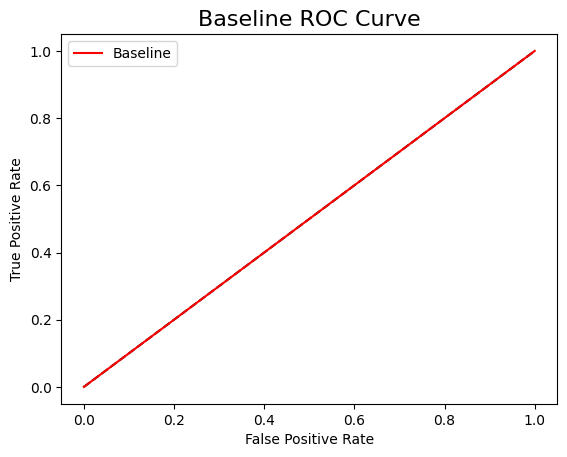

Sensitivity: 0.0
Specificity: 1.0
Precision: nan
AUC Score: 0.5


In [241]:
evaluation_without_probabilities(y_val, y_pred)

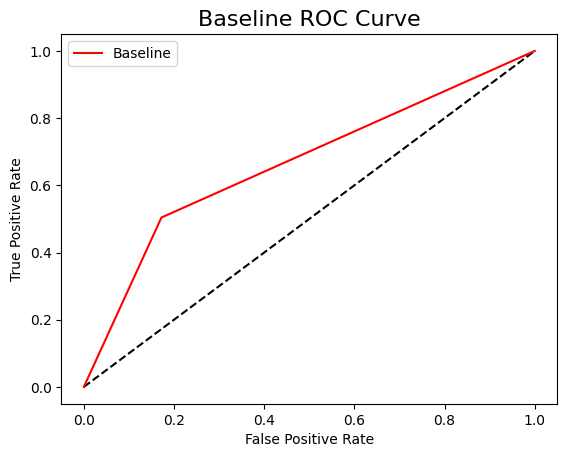

Sensitivity: 0.5041322314049587
Specificity: 0.8279158699808795
Precision: 0.5041322314049587
AUC Score: 0.666024050692919


In [247]:
dt1 = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_pred_class = dt1.predict(X_val)
y_pred_prob = dt1.predict_proba(X_val)[:,1]

evaluation_without_probabilities(y_val, y_pred_class)

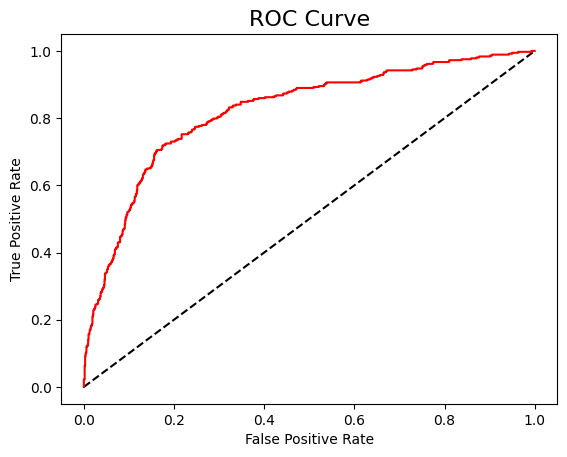

Sensitivity: 0.5261707988980716
Specificity: 0.8986615678776291
Precision: 0.6430976430976431
AUC Score: 0.8210722732276705


In [248]:
svc1 = svm.SVC(probability=True).fit(X_train, y_train)
y_pred_class = svc1.predict(X_val)
y_pred_prob = svc1.predict_proba(X_val)[:,1]

evaluation_with_probabilities(y_val,y_pred_class,y_pred_prob)

In [249]:
from imblearn.over_sampling import RandomOverSampler

# Apply RandomUnderSampler to balance the classes
ros = RandomOverSampler(sampling_strategy = 1)
X_res_over, y_res_over = ros.fit_resample(X_train, y_train)

# Combine the resampled features and target into a new DataFrame
df_balanced_ros = [X_res_over, y_res_over]

In [250]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = 1)

# Apply SMOTE to balance the classes
X_res_smote, y_res_smote = sm.fit_resample(X_train, y_train)

# Combine the resampled features and target into a new DataFrame
df_balanced_smote = [X_res_smote, y_res_smote]

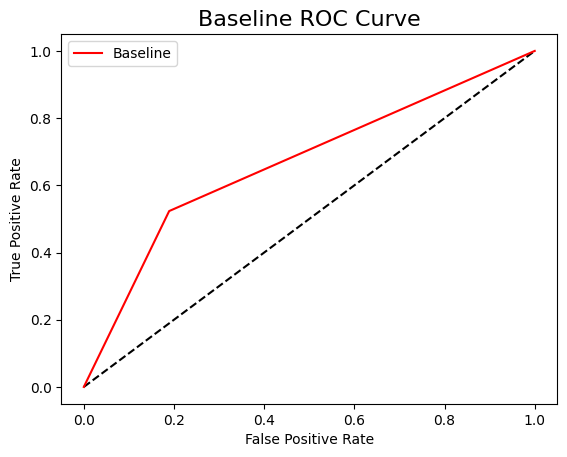

Sensitivity: 0.5234159779614325
Specificity: 0.8107074569789675
Precision: 0.4896907216494845
AUC Score: 0.6670617174702


In [252]:
dt2= tree.DecisionTreeClassifier().fit(X_res_over, y_res_over)
y_pred_class = dt2.predict(X_val)
y_pred_prob = dt2.predict_proba(X_val)[:,1]

evaluation_without_probabilities(y_val, y_pred_class)

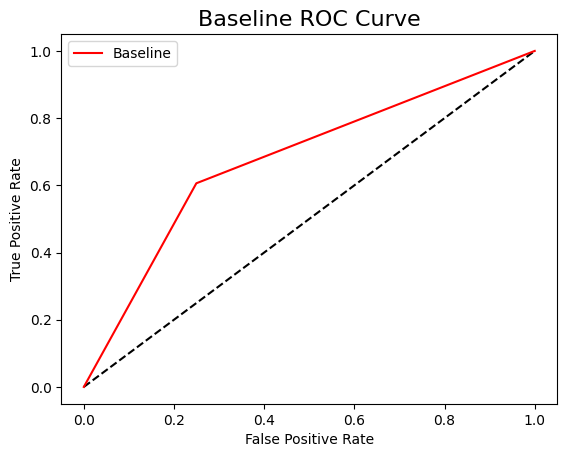

Sensitivity: 0.6060606060606061
Specificity: 0.7504780114722753
Precision: 0.4573804573804574
AUC Score: 0.6782693087664406


In [253]:
dt3= tree.DecisionTreeClassifier().fit(X_res_smote, y_res_smote)
y_pred_class = dt3.predict(X_val)
y_pred_prob = dt3.predict_proba(X_val)[:,1]

evaluation_without_probabilities(y_val, y_pred_class)

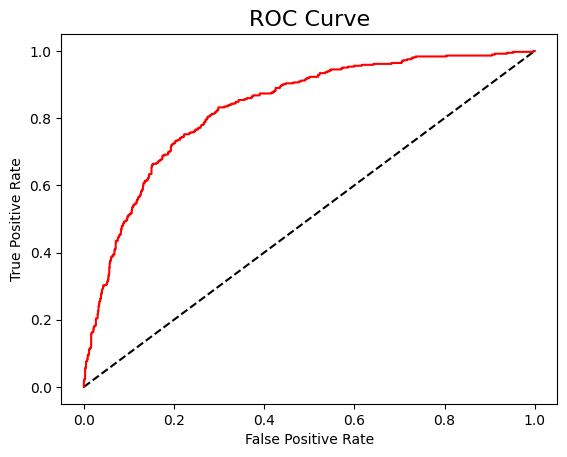

Sensitivity: 0.7988980716253443
Specificity: 0.7256214149139579
Precision: 0.5025996533795494
AUC Score: 0.8319203682926958


In [254]:
svc2 = svm.SVC(probability=True).fit(X_res_over, y_res_over)
y_pred_class = svc2.predict(X_val)
y_pred_prob = svc2.predict_proba(X_val)[:,1]

evaluation_with_probabilities(y_val,y_pred_class,y_pred_prob)

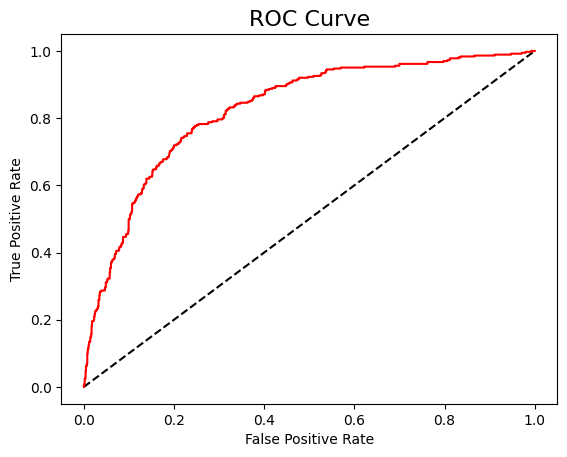

Sensitivity: 0.71900826446281
Specificity: 0.7954110898661568
Precision: 0.5494736842105263
AUC Score: 0.8261657949212269


In [259]:
svc3 = svm.SVC(probability=True).fit(X_res_smote, y_res_smote)
y_pred_class = svc3.predict(X_val)
y_pred_prob = svc3.predict_proba(X_val)[:,1]

evaluation_with_probabilities(y_val,y_pred_class,y_pred_prob)

In [ ]:
#J = sensitivity + specificity - 1